In [1]:
import torch
import numpy as np
import os.path as osp
import torch.nn.functional as F

from torch import nn
from torch import optim
from torch.utils.data import Dataset

from shapeglot.simple_utils import unpickle_data
from shapeglot.in_out.rnn_data_preprocessing import make_dataset_for_rnn_based_model
from shapeglot.in_out.shapeglot_dataset import ShapeglotDataset
from shapeglot.in_out.geometry import vgg_image_features, pc_ae_features
from shapeglot.models.neural_utils import MLPDecoder, smoothed_cross_entropy
from shapeglot.models.encoders import LanguageEncoder, PretrainedFeatures
from shapeglot.models.listener import Listener
from shapeglot.vis_utils import visualize_example
from shapeglot import vis_utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

### Define directories with data 
### [ assumes you have ran download_data.sh ]

In [2]:
top_data_dir = '../../data/main_data_for_chairs'
top_pretrained_feat_dir = '../../data/main_data_for_chairs/pretrained_features'
top_image_dir = osp.join(top_data_dir, 'images/shapenet/')
vis_utils.top_image_dir = top_image_dir

### Load data (Assumes you preprocessed the data, with notebooks/prepare_chair_in_context_data.ipynb)

In [3]:
# Load game-data
data_name = 'game_data.pkl'
game_data, word_to_int, int_to_word, int_to_sn_model, sn_model_to_int, sorted_sn_models =\
unpickle_data(osp.join(top_data_dir, data_name))

# Load pre-trained 2D/3D features.
vgg_feats_file = osp.join(top_pretrained_feat_dir, 'shapenet_chair_vgg_fc7_embedding.pkl')
vgg_feats = vgg_image_features(int_to_sn_model, 'chair', vgg_feats_file, python2_to_3=True)

pc_feats_file = osp.join(top_pretrained_feat_dir, 'shapenet_chair_pcae_128bneck_chamfer_embedding.npz')
pc_feats = pc_ae_features(int_to_sn_model, pc_feats_file)

### Prepare data for training (train/val splits, max-size, keep-only-correct etc.)

In [4]:
max_seq_len = 33              # Maximum size (in tokens) per utterance.
split_sizes = [0.8, 0.1, 0.1] # Train-val-test sizes.
random_seed = 2004
unique_test_geo = True        # If true, the test/train/val splits have 'targets' that are disjoint sets.
only_correct = True           # Drop all not correctly guessed instances.

net_data, split_ids, _, net_data_mask = \
make_dataset_for_rnn_based_model(game_data, 
                                 split_sizes, 
                                 max_seq_len,
                                 drop_too_long=True,
                                 only_correct=only_correct,
                                 unique_test_geo=unique_test_geo,
                                 replace_not_in_train=True,
                                 geo_condition=None, 
                                 bias_train=False, 
                                 seed=random_seed)


dataloaders = {}
num_workers = 8
batch_size = 2048 # Yes this is a big batch-size.

for split in ['train', 'val', 'test']:
    dataset = ShapeglotDataset(net_data[split])
    dataloaders[split] = torch.utils.data.DataLoader(dataset=dataset,
                                                     batch_size=batch_size,
                                                     shuffle=split=='train',
                                                     num_workers=num_workers)

unique geometries in train/test/val 3608 451 451


### Define Models

In [5]:
embedding_dim = 100  # Dimension of INPUT space of LSTM
n_hidden = 100       # LSTM hidden size
vocab_size = len(int_to_word)
train_epochs = 150
learning_rate = 0.005
reg_gamma = 0.005    # Weight regularization on FC layers

visual_encoder = PretrainedFeatures(torch.Tensor(vgg_feats), embed_size=embedding_dim)
pc_encoder = PretrainedFeatures(torch.Tensor(pc_feats), embed_size=embedding_dim)
lang_encoder = LanguageEncoder(n_hidden, embedding_dim, vocab_size)
mlp_decoder = MLPDecoder(n_hidden*2, [100, 50, 1], True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
listener = Listener(lang_encoder, visual_encoder, mlp_decoder, pc_encoder).to(device)
optimizer = optim.Adam(listener.parameters(), lr=learning_rate)

### Train the model (if you let it run for 150 epochs should reach ~78% accuracy)

In [6]:
best_val_accuracy = 0.0
best_test_accuracy = 0.0

for epoch in range(1, train_epochs+1):
    for phase in ['train', 'val', 'test']:
        if phase == 'train':            
            listener.train()
        else:
            listener.eval()

        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data.
        for context_ids, targets, tokens in dataloaders[phase]:
            context_ids = context_ids.to(device)
            targets = targets.to(device)
            tokens = tokens.to(device)
    
            with torch.set_grad_enabled(phase == 'train'):
                logits = listener(context_ids, tokens)
                loss = smoothed_cross_entropy(logits, targets)                            
                reg_loss = 0.0
                
                for p in visual_encoder.named_parameters():
                    if 'fc.weight' == p[0]:
                        reg_loss += p[1].norm(2)
                
                for p in pc_encoder.named_parameters():
                    if 'fc.weight' == p[0]:
                        reg_loss += p[1].norm(2)
                        
                reg_loss *= reg_gamma                
                loss += reg_loss
                
                _, preds = torch.max(logits, 1)

                # backward + optimize only if in training phase
                if phase == 'train':
                    listener.zero_grad()
                    loss.backward()
                    optimizer.step()
            
            # statistics
            running_loss += loss.item() * targets.size(0)
            running_corrects += torch.sum(preds == targets)
        
        n_examples = len(dataloaders[phase].dataset)
        epoch_loss = running_loss / n_examples
        epoch_acc = running_corrects.double() / n_examples
        
        if phase == 'val':
            if epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                val_improved = True
            else:
                val_improved = False
        
        if phase == 'test' and val_improved:
            best_test_accuracy = epoch_acc
                        
        print('{} Epoch {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, phase, epoch_loss, epoch_acc))
    print('Best test so far: {:.4f}'.format(best_test_accuracy))

1 Epoch train Loss: 1.1537 Acc: 0.3760
1 Epoch val Loss: 1.1093 Acc: 0.4132
1 Epoch test Loss: 1.1070 Acc: 0.4201
Best test so far: 0.4201
2 Epoch train Loss: 1.0828 Acc: 0.4793
2 Epoch val Loss: 1.0344 Acc: 0.5322
2 Epoch test Loss: 1.0317 Acc: 0.5502
Best test so far: 0.5502
3 Epoch train Loss: 1.0187 Acc: 0.5621
3 Epoch val Loss: 0.9731 Acc: 0.6127
3 Epoch test Loss: 0.9688 Acc: 0.6213
Best test so far: 0.6213
4 Epoch train Loss: 0.9753 Acc: 0.6082
4 Epoch val Loss: 0.9485 Acc: 0.6416
4 Epoch test Loss: 0.9314 Acc: 0.6588
Best test so far: 0.6588
5 Epoch train Loss: 0.9429 Acc: 0.6345
5 Epoch val Loss: 0.9244 Acc: 0.6550
5 Epoch test Loss: 0.9078 Acc: 0.6760
Best test so far: 0.6760
6 Epoch train Loss: 0.9152 Acc: 0.6551
6 Epoch val Loss: 0.8974 Acc: 0.6717
6 Epoch test Loss: 0.8794 Acc: 0.6903
Best test so far: 0.6903
7 Epoch train Loss: 0.9004 Acc: 0.6691
7 Epoch val Loss: 0.8985 Acc: 0.6841
7 Epoch test Loss: 0.8745 Acc: 0.7005
Best test so far: 0.7005
8 Epoch train Loss: 0.8894 

59 Epoch train Loss: 0.7236 Acc: 0.8058
59 Epoch val Loss: 0.7971 Acc: 0.7674
59 Epoch test Loss: 0.7720 Acc: 0.7805
Best test so far: 0.7746
60 Epoch train Loss: 0.7187 Acc: 0.8098
60 Epoch val Loss: 0.7865 Acc: 0.7687
60 Epoch test Loss: 0.7625 Acc: 0.7783
Best test so far: 0.7746
61 Epoch train Loss: 0.7180 Acc: 0.8077
61 Epoch val Loss: 0.7887 Acc: 0.7677
61 Epoch test Loss: 0.7589 Acc: 0.7797
Best test so far: 0.7746
62 Epoch train Loss: 0.7166 Acc: 0.8098
62 Epoch val Loss: 0.7830 Acc: 0.7689
62 Epoch test Loss: 0.7605 Acc: 0.7779
Best test so far: 0.7746
63 Epoch train Loss: 0.7139 Acc: 0.8099
63 Epoch val Loss: 0.7865 Acc: 0.7698
63 Epoch test Loss: 0.7610 Acc: 0.7780
Best test so far: 0.7780
64 Epoch train Loss: 0.7122 Acc: 0.8100
64 Epoch val Loss: 0.7907 Acc: 0.7670
64 Epoch test Loss: 0.7650 Acc: 0.7793
Best test so far: 0.7780
65 Epoch train Loss: 0.7158 Acc: 0.8111
65 Epoch val Loss: 0.7876 Acc: 0.7670
65 Epoch test Loss: 0.7728 Acc: 0.7798
Best test so far: 0.7780
66 Epo

116 Epoch test Loss: 0.7618 Acc: 0.7793
Best test so far: 0.7828
117 Epoch train Loss: 0.6711 Acc: 0.8418
117 Epoch val Loss: 0.7805 Acc: 0.7707
117 Epoch test Loss: 0.7661 Acc: 0.7746
Best test so far: 0.7828
118 Epoch train Loss: 0.6714 Acc: 0.8402
118 Epoch val Loss: 0.7803 Acc: 0.7775
118 Epoch test Loss: 0.7704 Acc: 0.7725
Best test so far: 0.7828
119 Epoch train Loss: 0.6744 Acc: 0.8414
119 Epoch val Loss: 0.7894 Acc: 0.7691
119 Epoch test Loss: 0.7733 Acc: 0.7769
Best test so far: 0.7828
120 Epoch train Loss: 0.6724 Acc: 0.8425
120 Epoch val Loss: 0.7810 Acc: 0.7775
120 Epoch test Loss: 0.7670 Acc: 0.7781
Best test so far: 0.7828
121 Epoch train Loss: 0.6739 Acc: 0.8401
121 Epoch val Loss: 0.7842 Acc: 0.7734
121 Epoch test Loss: 0.7663 Acc: 0.7779
Best test so far: 0.7828
122 Epoch train Loss: 0.6734 Acc: 0.8404
122 Epoch val Loss: 0.7801 Acc: 0.7757
122 Epoch test Loss: 0.7663 Acc: 0.7787
Best test so far: 0.7828
123 Epoch train Loss: 0.6695 Acc: 0.8421
123 Epoch val Loss: 0.78

### Collect responses of a trained (!) listener (last epoch) and visualize what its predictions.

In [7]:
listener.eval()
guesses = []
scores = []
phase = 'test'
score = 0.0
for context_ids, targets, tokens in dataloaders[phase]:
    context_ids = context_ids.to(device)
    targets = targets.to(device)
    tokens = tokens.to(device)        
    with torch.set_grad_enabled(phase == 'train'):
        logits = listener(context_ids, tokens)
        scores.append(F.softmax(logits, dim=1).to('cpu').numpy())
        _, preds = torch.max(logits, 1)
        guesses.append(preds.to('cpu').numpy())
        score += torch.sum(preds == targets)
score = score.item() / float(len(dataloaders[phase].dataset))
guesses = np.hstack(guesses)
scores = np.vstack(scores)
test_data = dataloaders['test'].dataset

Predicted Probabilities: 0.07 0.12 0.81
Utterance: round seat , flat back 
Guessed correct: False
Target: 1


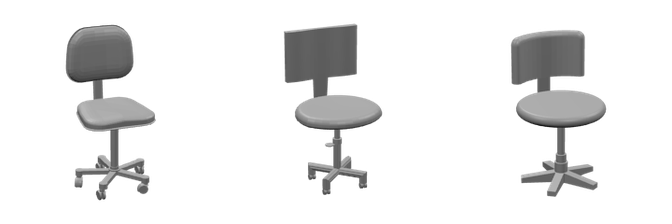

In [12]:
rid = np.random.randint(len(test_data))
chair_ids, target, utterance = test_data[rid]
guess = guesses[rid] == target
print ('Predicted Probabilities: {:.2f} {:.2f} {:.2f}'.format(*scores[rid]))
visualize_example(chair_ids, utterance, target, sorted_sn_models, int_to_word, guess=guess)